In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score
%matplotlib notebook

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


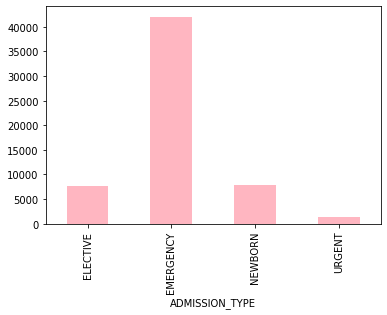

In [ ]:
df_adm = pd.read_csv('/content/sample_data/ADMISSIONS.csv')
df_adm.head()
fig = plt.figure()
df_adm.groupby(['ADMISSION_TYPE']).size().plot.bar(color = 'lightpink')

In [ ]:
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S')
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)
df_adm.loc[df_adm.SUBJECT_ID == 801, ['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
df_adm.loc[df_adm.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


In [ ]:
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN
df_adm.loc[df_adm.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]


,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


In [ ]:
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])\
[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')
df_adm.loc[df_adm.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


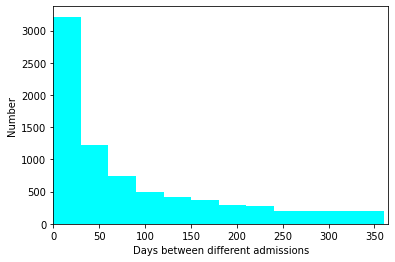

In [ ]:

fig = plt.figure() 
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins = range(0,365,30), color = 'cyan')
plt.xlim([0,365])
plt.xlabel('Days between different admissions')
plt.ylabel('Number')
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


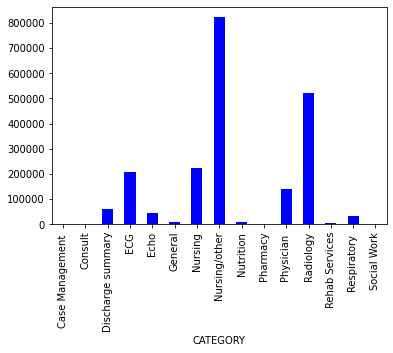

In [ ]:
df_notes = pd.read_csv("/content/drive/MyDrive/NOTEEVENTS.csv")
df_notes.CATEGORY.unique()
fig = plt.figure() 
df_notes.groupby(['CATEGORY']).size().plot.bar(color = 'blue')

In [ ]:
df_notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [ ]:
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], on = ['SUBJECT_ID','HADM_ID'],how = 'left')
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [ ]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

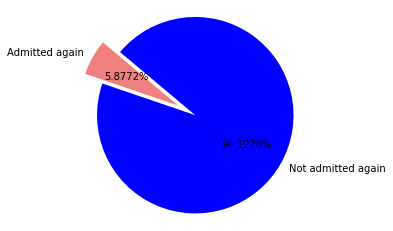

In [ ]:
fig = plt.figure()
labels = ['Admitted again', 'Not admitted again']
sizes = [(df_adm_notes_clean.OUTPUT_LABEL == 1).sum(), (df_adm_notes_clean.OUTPUT_LABEL == 0).sum()]
colors = ['lightcoral', 'blue']
explode = [0.2,0]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%4.4f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

In [ ]:

df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)
df_train_all = df_adm_notes_clean.drop(df_valid_test.index)

In [ ]:
df_train_all.to_csv('/content/sample_data/df_train_all.csv',index=False)
df_valid.to_csv('/content/sample_data/df_valid.csv',index=False)
df_test.to_csv('/content/sample_data/df_test.csv',index=False)
df_test = pd.read_csv('/content/sample_data/df_test.csv') 
df_valid = pd.read_csv('/content/sample_data/df_valid.csv') 
df_train_all= pd.read_csv('/content/sample_data/df_train_all.csv') 


In [ ]:
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
n = np.min([len(df_train_pos),len(df_train_neg)])
df_train = pd.concat([df_train_pos.sample(n = n, random_state = 42),df_train_neg.sample(n = n, random_state = 42)],axis = 0)
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)


In [ ]:
df_train.to_csv('/content/sample_data/df_train.csv',index=False)
df_train = pd.read_csv('/content/sample_data/df_train.csv')

In [ ]:
def preprocess_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [ ]:
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [ ]:
def tokenizeAgain(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [ ]:
vect = CountVectorizer(tokenizer = tokenizer_two)
vect.fit(sample_text)
X = vect.transform(sample_text)
X.toarray()
vect.get_feature_names()
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizerAgain)
vect.fit(df_train.TEXT.values)
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


,negative,positive,total
the,71054,76756,147810
and,62455,71658,134113
to,53226,62085,115311
of,51303,60491,111794
was,48074,53521,101595
with,38036,44583,82619
a,35428,41629,77057
on,32290,39765,72055
mg,27718,39045,66763
in,29567,34755,64322


In [ ]:
vect = CountVectorizer(max_features = 4000, tokenizer = tokenizer_two, stop_words = some_stop_words)
vect.fit(df_train.TEXT.values)
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train Prevalence:0.500
Valid Prevalence:0.057
Train AUC:0.756
Valid AUC:0.705
Train Accuracy:0.688
Valid Accuracy:0.710
Train Recall:0.625
Valid Recall:0.593
Train Precision:0.716
Valid Precision:0.112
Train Specificity:0.751
Valid Specificity:0.717


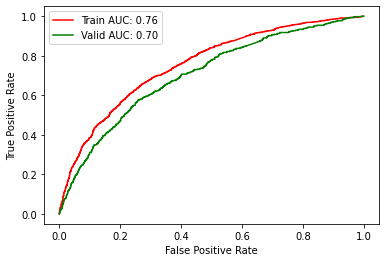

In [ ]:
clf = LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return sum((y_actual == 1)) /len(y_actual)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
thresh = 0.5
auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train Prevalence:%.3f'%calc_prevalence(y_train))
print('Valid Prevalence:%.3f'%calc_prevalence(y_valid))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train Accuracy:%.3f'%accuracy_score(y_train, y_train_preds >= thresh))
print('Valid Accuracy:%.3f'%accuracy_score(y_valid, y_valid_preds >= thresh))

print('Train Recall:%.3f'%recall_score(y_train, y_train_preds>= thresh))
print('Valid Recall:%.3f'%recall_score(y_valid, y_valid_preds>= thresh))

print('Train Precision:%.3f'%precision_score(y_train, y_train_preds>= thresh))
print('Valid Precision:%.3f'%precision_score(y_valid, y_valid_preds>= thresh))

print('Train Specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid Specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

fig = plt.figure()
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'g-',label = 'Valid AUC: %.2f'%auc_valid)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.xticks()
plt.yticks()
plt.show()


In [ ]:
feature_importances = pd.DataFrame(clf.coef_[0],index = vect.get_feature_names(),columns=['importance']).sort_values('importance',ascending=False)
more_stop_words = ['the','was','with','a','on','in','for','name','is','patient','s','he','at','as','or','one','she','his','her','am','were','you','pt','pm','by','be','had','your','this','date','from','there','an','that','p','are','have','has','h','but','o','namepattern','which','every','also','should','if','it','been','who','during', 'x']

vect = CountVectorizer(lowercase = True, max_features = 4000, tokenizer = tokenizer_two,stop_words = more_stop_words)

vect.fit(df_train.TEXT.values)
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
Cs = [0.00002, 0.00005, 0.0002, 0.0004, 0.002, 0.006]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))
for ii in range(len(Cs)):
    C = Cs[ii]
    print('C:', C)
    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)
    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.4f'%auc_train)
    print('Valid AUC:%.4f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

C: 2e-05
Train AUC:0.7022
Valid AUC:0.6822
C: 5e-05
Train AUC:0.7301
Valid AUC:0.6971
C: 0.0002
Train AUC:0.7815
Valid AUC:0.7157
C: 0.0004


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train AUC:0.8128
Valid AUC:0.7214
C: 0.002


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train AUC:0.8951
Valid AUC:0.7141
C: 0.006
Train AUC:0.9460
Valid AUC:0.6956


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


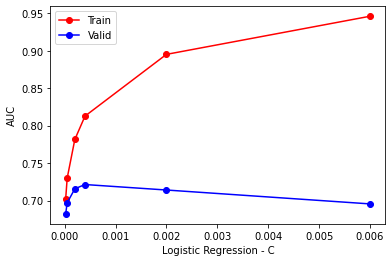

In [ ]:
fig = plt.figure()
plt.plot(Cs, train_aucs,'ro-', label ='Train')
plt.plot(Cs, valid_aucs, 'bo-', label='Valid')
plt.legend()
plt.xlabel('Logistic Regression - C')
plt.ylabel('AUC')
plt.show()